# TimeGAN Tutorial

## Time-series Generative Adversarial Networks

- Paper: Jinsung Yoon, Daniel Jarrett, Mihaela van der Schaar, "Time-series Generative Adversarial Networks," Neural Information Processing Systems (NeurIPS), 2019.

- Paper link: https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks

- Last updated Date: April 24th 2020

- Code author: Jinsung Yoon (jsyoon0823@gmail.com)

This notebook describes the user-guide of a time-series synthetic data generation application using timeGAN framework. We use Stock, Energy, and Sine dataset as examples.

### Prerequisite
Clone https://github.com/jsyoon0823/timeGAN.git to the current directory.

## Necessary packages and functions call

- timegan: Synthetic time-series data generation module
- data_loading: 2 real datasets and 1 synthetic datasets loading and preprocessing
- metrics: 
    - discriminative_metrics: classify real data from synthetic data
    - predictive_metrics: train on synthetic, test on real
    - visualization: PCA and tSNE analyses

In [1]:
## Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1. TimeGAN model
from timegan import timegan
# 2. Data loading
from data_loading import real_data_loading, sine_data_generation
# 3. Metrics
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization

import tensorflow as tf

import os

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
config = tf.compat.v1.ConfigProto() # Another Version: config = tf.ConfigProto()
config.gpu_options.allow_growth = True

## Data Loading

Load original dataset and preprocess the loaded data.

- data_name: stock, energy, or sine
- seq_len: sequence length of the time-series data

In [3]:
## Data loading
data_name = 'stock'
seq_len = 24

if data_name in ['stock', 'energy']:
  ori_data = real_data_loading(data_name, seq_len)
elif data_name == 'sine':
  # Set number of samples and its dimensions
  no, dim = 10000, 5
  ori_data = sine_data_generation(no, seq_len, dim)
    
print(data_name + ' dataset is ready.')

stock dataset is ready.


## Set network parameters

TimeGAN network parameters should be optimized for different datasets.

- module: gru, lstm, or lstmLN
- hidden_dim: hidden dimensions
- num_layer: number of layers
- iteration: number of training iterations
- batch_size: the number of samples in each batch

In [9]:
## Newtork parameters
parameters = dict()

parameters['module'] = 'gru' 
parameters['hidden_dim'] = 24
parameters['num_layer'] = 3
parameters['iterations'] = 100
parameters['batch_size'] = 128

## Run TimeGAN for synthetic time-series data generation

TimeGAN uses the original data and network parameters to return the generated synthetic data.

In [10]:
# Run TimeGAN
generated_data = timegan(ori_data, parameters)   
print('Finish Synthetic Data Generation')

2021-07-28 01:31:22.473101: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla V100-PCIE-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.38
pciBusID: 0000:5e:00.0
2021-07-28 01:31:22.473183: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-07-28 01:31:22.473289: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-07-28 01:31:22.473300: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2021-07-28 01:31:22.473311: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2021-07-28 01:31:22.473322: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10.0
2021-07-28 01:31:22.473333: I tensorflow/stream_executor

Start Embedding Network Training
step: 0/100, e_loss: 0.3232
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/100, s_loss: 0.1746
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/100, d_loss: 2.1746, g_loss_u: 0.6101, g_loss_s: 0.0575, g_loss_v: 0.2928, e_loss_t0: 0.1161
Finish Joint Training
Finish Synthetic Data Generation


In [11]:
generated_data.shape

(3661, 24, 6)

In [12]:
type(ori_data), type(generated_data)

(list, numpy.ndarray)

In [13]:
generated_data[:2,:,:]

array([[[0.26330659, 0.27781051, 0.26481654, 0.28239596, 0.25614691,
         0.08329678],
        [0.28010416, 0.27859303, 0.2733949 , 0.29042932, 0.27228063,
         0.04506287],
        [0.35934621, 0.35827139, 0.35755487, 0.35139647, 0.35170835,
         0.03824407],
        [0.47435418, 0.47396365, 0.48697819, 0.45148847, 0.46317366,
         0.03036267],
        [0.56709903, 0.56758511, 0.58147587, 0.53699094, 0.55798781,
         0.02358356],
        [0.63478667, 0.63494629, 0.6491829 , 0.60117328, 0.62904549,
         0.01984537],
        [0.68292272, 0.68420887, 0.69612289, 0.65050644, 0.67864448,
         0.01777831],
        [0.71389979, 0.71565199, 0.72446087, 0.68511623, 0.70885479,
         0.01648551],
        [0.73148453, 0.7326535 , 0.73931331, 0.70615363, 0.72493833,
         0.01564652],
        [0.7401219 , 0.74061716, 0.74588567, 0.71746308, 0.73251629,
         0.01511973],
        [0.74373251, 0.74398375, 0.74825466, 0.72320074, 0.73584807,
         0.01481766],

## Evaluate the generated data

### 1. Discriminative score

To evaluate the classification accuracy between original and synthetic data using post-hoc RNN network. The output is |classification accuracy - 0.5|.

- metric_iteration: the number of iterations for metric computation.

In [ ]:
metric_iteration = 5

discriminative_score = list()
for _ in range(metric_iteration):
  temp_disc = discriminative_score_metrics(ori_data, generated_data)
  discriminative_score.append(temp_disc)

print('Discriminative score: ' + str(np.round(np.mean(discriminative_score), 4)))

## Evaluate the generated data

### 2. Predictive score

To evaluate the prediction performance on train on synthetic, test on real setting. More specifically, we use Post-hoc RNN architecture to predict one-step ahead and report the performance in terms of MAE.

In [ ]:
predictive_score = list()
for tt in range(metric_iteration):
  temp_pred = predictive_score_metrics(ori_data, generated_data)
  predictive_score.append(temp_pred)   
    
print('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))

## Evaluate the generated data

### 3. Visualization

We visualize the original and synthetic data distributions using PCA and tSNE analysis.

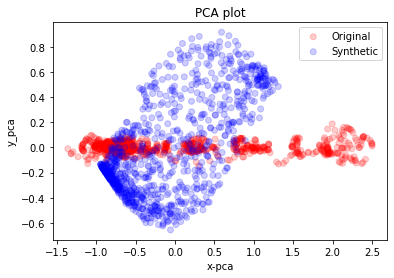

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.096s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.048582
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.927574
[t-SNE] KL divergence after 300 iterations: 0.702169


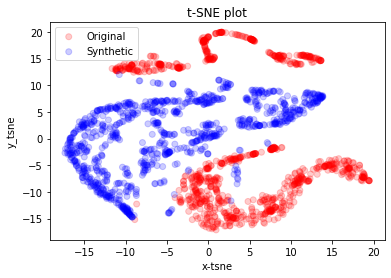

In [14]:
visualization(ori_data, generated_data, 'pca')
visualization(ori_data, generated_data, 'tsne')